<a href="https://colab.research.google.com/drive/1O5sPD2ktmODXE3yyKU2VZz6kIN_-a1eM">Abre este Jupyter en Google Colab</a>

# Caso práctico: _Random Forest_

En este caso de uso práctico se pretende resolver un problema de detección de malware en dispositivos Android mediante el análisis del tráfico de red que genera el dispositivo mediante el uso de conjuntos de árboles de decisión.

## Conjunto de datos: Detección de malware en Android

### Descripción
The sophisticated and advanced Android malware is able to identify the presence of the emulator used by the malware analyst and in response, alter its behavior to evade detection. To overcome this issue, we installed the Android applications on the real device and captured its network traffic. See our publicly available Android Sandbox.

CICAAGM dataset is captured by installing the Android apps on the real smartphones semi-automated. The dataset is generated from 1900 applications with the following three categories:

**1. Adware (250 apps)**
* Airpush: Designed to deliver unsolicited advertisements to the user’s systems for information stealing.
* Dowgin: Designed as an advertisement library that can also steal the user’s information.
* Kemoge: Designed to take over a user’s Android device. This adware is a hybrid of botnet and disguises itself as popular apps via repackaging.
* Mobidash: Designed to display ads and to compromise user’s personal information.
* Shuanet: Similar to Kemoge, Shuanet also is designed to take over a user’s device.

**2. General Malware (150 apps)**
* AVpass: Designed to be distributed in the guise of a Clock app.
* FakeAV: Designed as a scam that tricks user to purchase a full version of the software in order to re-mediate non-existing infections.
* FakeFlash/FakePlayer: Designed as a fake Flash app in order to direct users to a website (after successfully installed).
* GGtracker: Designed for SMS fraud (sends SMS messages to a premium-rate number) and information stealing.
* Penetho: Designed as a fake service (hacktool for Android devices that can be used to crack the WiFi password). The malware is also able to infect the user’s computer via infected email attachment, fake updates, external media and infected documents.

**3. Benign (1500 apps)**
* 2015 GooglePlay market (top free popular and top free new)
* 2016 GooglePlay market (top free popular and top free new)

### Ficheros de datos
* pcap files – the network traffic of both the malware and benign (20% malware and 80% benign)
* <span style="color:green">.csv files - the list of extracted network traffic features generated by the CIC-flowmeter</span>

### Descarga de los ficheros de datos
https://www.unb.ca/cic/datasets/android-adware.html

### Referencias adicionales sobre el conjunto de datos
_Arash Habibi Lashkari, Andi Fitriah A. Kadir, Hugo Gonzalez, Kenneth Fon Mbah and Ali A. Ghorbani, “Towards a Network-Based Framework for Android Malware Detection and Characterization”, In the proceeding of the 15th International Conference on Privacy, Security and Trust, PST, Calgary, Canada, 2017._

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score

In [2]:
import warnings
# Ignoramos algunos warnings que se producen por invocar el modelo sin el nombre de las características
warnings.filterwarnings('ignore', category=UserWarning, message='.*X does not have valid feature names.*')

## Funciones auxiliares

In [3]:
# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [4]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

In [5]:
def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "WITHOUT preparation:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "WITH preparation:", metric(y_prep_pred, y_prep, average='weighted'))

## 1. Lectura del conjunto de datos

In [6]:
df = pd.read_csv('datasets/TotalFeatures-ISCXFlowMeter.csv')

## 2. Visualización del conjunto de datos

In [7]:
df.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
0,1020586,668,1641,35692,2276876,52,52,679,1390,53.431138,...,0.0,-1,0.0,2,4194240,1853440,1640,668,32,benign
1,80794,1,1,75,124,75,124,75,124,75.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
2,998,3,0,187,0,52,-1,83,-1,62.333333,...,0.0,-1,0.0,4,101888,-1,0,3,32,benign
3,189868,9,9,1448,6200,52,52,706,1390,160.888889,...,0.0,-1,0.0,2,4194240,2722560,8,9,32,benign
4,110577,4,6,528,1422,52,52,331,1005,132.000000,...,0.0,-1,0.0,2,155136,31232,5,4,32,benign
5,261876,7,6,1618,882,52,52,730,477,231.142857,...,0.0,-1,0.0,2,4194240,926720,3,7,32,benign
6,14,2,0,104,0,52,-1,52,-1,52.000000,...,0.0,-1,0.0,3,5824,-1,0,2,32,benign
7,29675,1,1,71,213,71,213,71,213,71.000000,...,0.0,-1,0.0,2,0,0,0,1,0,benign
8,806635,4,0,239,0,52,-1,83,-1,59.750000,...,0.0,-1,0.0,5,107008,-1,0,4,32,benign
9,56620,3,2,1074,719,52,52,592,667,358.000000,...,0.0,-1,0.0,3,128512,10816,1,3,32,benign


In [8]:
df.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,6.319550e+05,631955.000000,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.000000,631955.000000,631955.000000,631955.000000,...,6.319550e+05,6.319550e+05,6.319550e+05,6.319550e+05,631955.000000,6.319550e+05,6.319550e+05,631955.000000,631955.00000,631955.000000
mean,2.195245e+07,6.728514,10.431934,9.540172e+02,1.206042e+04,141.475727,44.357688,263.675901,183.248084,174.959706,...,1.997327e+07,2.031228e+07,2.075238e+07,4.663875e+05,2.360896,9.620796e+05,3.104519e+05,9.733144,6.72471,19.965713
std,1.900578e+08,174.161354,349.424019,8.235040e+04,4.824716e+05,157.680880,89.099554,289.644383,371.863224,162.024811,...,1.897986e+08,1.897902e+08,1.899721e+08,6.199704e+06,3.041810,1.705655e+06,6.647956e+05,347.877923,174.13813,14.914261
min,-1.800000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,-1.000000e+00,-1.000000e+00,0.000000,0.00000,0.000000
25%,0.000000e+00,1.000000,0.000000,6.900000e+01,0.000000e+00,52.000000,-1.000000,52.000000,-1.000000,52.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,0.000000e+00,-1.000000e+00,0.000000,1.00000,0.000000
50%,2.445000e+04,1.000000,0.000000,1.840000e+02,0.000000e+00,52.000000,-1.000000,83.000000,-1.000000,83.000000,...,-1.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,2.000000,8.761600e+04,-1.000000e+00,0.000000,1.00000,32.000000
75%,1.759751e+06,3.000000,1.000000,4.270000e+02,1.670000e+02,108.000000,52.000000,421.000000,115.000000,356.000000,...,1.013498e+06,1.291379e+06,1.306116e+06,0.000000e+00,2.000000,3.046400e+05,9.049600e+04,1.000000,3.00000,32.000000
max,4.431076e+10,48255.000000,74768.000000,4.049644e+07,1.039222e+08,1390.000000,1390.000000,1500.000000,1390.000000,1390.000000,...,4.431072e+10,4.430000e+10,4.431072e+10,8.470000e+08,2269.000000,4.194240e+06,4.194240e+06,74524.000000,48255.00000,44.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631955 entries, 0 to 631954
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration                 631955 non-null  int64  
 1   total_fpackets           631955 non-null  int64  
 2   total_bpackets           631955 non-null  int64  
 3   total_fpktl              631955 non-null  int64  
 4   total_bpktl              631955 non-null  int64  
 5   min_fpktl                631955 non-null  int64  
 6   min_bpktl                631955 non-null  int64  
 7   max_fpktl                631955 non-null  int64  
 8   max_bpktl                631955 non-null  int64  
 9   mean_fpktl               631955 non-null  float64
 10  mean_bpktl               631955 non-null  float64
 11  std_fpktl                631955 non-null  float64
 12  std_bpktl                631955 non-null  float64
 13  total_fiat               631955 non-null  int64  
 14  tota

In [10]:
print("Longitud del conjunto de datos:", len(df))
print("Número de características del conjunto de datos:", len(df.columns))

Longitud del conjunto de datos: 631955
Número de características del conjunto de datos: 80


In [11]:
df["calss"].value_counts()

calss
benign            471597
asware            155613
GeneralMalware      4745
Name: count, dtype: int64

### Buscando correlaciones

In [12]:
# Transformamos la variable de salida a numérica para calcular correlaciones
X = df.copy()
X['calss'] = X['calss'].factorize()[0]

In [13]:
# Calculamos correlaciones
corr_matrix = X.corr()
corr_matrix["calss"].sort_values(ascending=False)

calss                     1.000000
flow_fin                  0.286175
min_seg_size_forward      0.258352
Init_Win_bytes_forward    0.129425
std_fpktl                 0.123758
                            ...   
furg_cnt                       NaN
burg_cnt                       NaN
flow_urg                       NaN
flow_cwr                       NaN
flow_ece                       NaN
Name: calss, Length: 80, dtype: float64

In [14]:
X.corr()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
total_fpackets,0.004837,1.000000,0.924622,0.425756,0.904007,-0.018958,0.005252,0.024685,0.086255,-0.007910,...,0.001614,0.002267,0.017229,0.016089,0.050201,0.059224,0.902713,0.999866,0.018198,0.018377
total_bpackets,0.004011,0.924622,1.000000,0.156780,0.997268,-0.017667,0.006912,0.018170,0.086886,-0.016104,...,0.000922,0.001617,0.016230,-0.000493,0.048190,0.058435,0.997580,0.924746,0.015124,0.019430
total_fpktl,0.001673,0.425756,0.156780,1.000000,0.090082,-0.003099,0.000803,0.021278,0.022088,0.022409,...,0.000335,0.000609,0.009896,0.001657,0.013283,0.015991,0.088422,0.425789,0.005477,0.000679
total_bpktl,0.003518,0.904007,0.997268,0.090082,1.000000,-0.014926,0.005966,0.012560,0.079905,-0.017328,...,0.000812,0.001452,0.014336,-0.000293,0.043571,0.053134,0.999616,0.904129,0.012139,0.019838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Init_Win_bytes_backward,0.029712,0.059224,0.058435,0.015991,0.053134,-0.268444,0.038319,0.429893,0.593143,-0.030004,...,0.026959,0.029512,0.097316,-0.052507,0.811204,1.000000,0.056761,0.059242,0.333701,0.069405
RRT_samples_clnt,0.003785,0.902713,0.997580,0.088422,0.999616,-0.016659,0.006156,0.015727,0.084280,-0.017595,...,0.000893,0.001560,0.015200,-0.000437,0.046784,0.056761,1.000000,0.902834,0.014299,0.019679
Act_data_pkt_forward,0.004838,0.999866,0.924746,0.425789,0.904129,-0.018947,0.005264,0.024705,0.086278,-0.007893,...,0.001617,0.002269,0.017233,0.000734,0.050220,0.059242,0.902834,1.000000,0.018229,0.018391
min_seg_size_forward,0.082955,0.018198,0.015124,0.005477,0.012139,-0.686154,-0.189824,-0.074763,0.217989,-0.524024,...,0.077943,0.079324,0.048803,0.052177,0.394743,0.333701,0.014299,0.018229,1.000000,0.258352


In [15]:
# Se puede llegar a valorar quedarnos con aquellas que tienen mayor correlación
corr_matrix[corr_matrix["calss"] > 0.05]

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward,calss
duration,1.000000,0.004837,0.004011,0.001673,0.003518,-0.064100,-0.027231,0.008761,0.042925,-0.043746,...,0.998901,0.999458,0.047582,0.016532,0.027610,0.029712,0.003785,0.004838,0.082955,0.067066
max_bpktl,0.042925,0.086255,0.086886,0.022088,0.079905,-0.277317,0.275923,0.492194,1.000000,-0.018358,...,0.035413,0.038732,0.127548,-0.044916,0.586742,0.593143,0.084280,0.086278,0.217989,0.073212
mean_bpktl,0.025117,0.139142,0.151761,0.018954,0.146437,-0.280648,0.465208,0.342392,0.895712,-0.096195,...,0.018533,0.021519,0.114949,-0.045442,0.452735,0.478823,0.150252,0.139172,0.122226,0.064753
std_fpktl,0.039350,0.010172,0.002331,0.011416,-0.003162,-0.245792,0.052877,0.817873,0.564243,0.259588,...,0.031418,0.033978,0.096844,-0.020885,0.558249,0.532900,0.000140,0.010182,0.301237,0.123758
std_bpktl,0.048743,0.020324,0.014005,0.007763,0.007768,-0.225143,0.035371,0.534532,0.941626,0.051756,...,0.042562,0.045450,0.113854,-0.033991,0.594790,0.577954,0.012050,0.020335,0.276055,0.072953
total_fiat,0.943898,0.002190,0.001718,0.000708,0.001546,-0.049879,-0.031218,-0.029233,-0.005961,-0.048869,...,0.943668,0.943339,0.015254,0.020302,-0.011637,-0.016421,0.001615,0.002190,0.065124,0.064770
min_fiat,0.841692,-0.001975,-0.002172,-0.000746,-0.001820,-0.040046,-0.036619,-0.052289,-0.035963,-0.053811,...,0.843330,0.842512,-0.005389,0.015316,-0.027350,-0.033944,-0.002037,-0.001974,0.051853,0.074491
max_fiat,0.943438,-0.000420,-0.000714,-0.000389,-0.000548,-0.046977,-0.032630,-0.032606,-0.009878,-0.049032,...,0.944412,0.943971,0.012557,0.017756,-0.012317,-0.016206,-0.000644,-0.000418,0.061285,0.064875
mean_fiat,0.918036,-0.001970,-0.002241,-0.000728,-0.001907,-0.042455,-0.036056,-0.048712,-0.032412,-0.052892,...,0.919653,0.918797,-0.003523,0.016958,-0.025823,-0.032466,-0.002113,-0.001968,0.055151,0.071397
std_flowpktl,0.036942,0.087741,0.087307,0.024298,0.080666,-0.262968,0.338513,0.631466,0.911584,0.095976,...,0.030013,0.033100,0.120257,-0.035737,0.580266,0.586355,0.084725,0.087764,0.219346,0.119375


## 3. División del conjunto de datos

In [16]:
# Dividimos el conjunto de datos
train_set, val_set, test_set = train_val_test_split(df)

In [17]:
X_train, y_train = remove_labels(train_set, 'calss')
X_val, y_val = remove_labels(val_set, 'calss')
X_test, y_test = remove_labels(test_set, 'calss')

## 4. Escalando el conjunto de datos

Es importante comprender que los árboles de decisión son algoritmos que **no requieren demasiada preparación de los datos** concretamente, no requieren la realización de escalado o normalización. En este ejercicio se va a realizar escalado al conjunto de datos y se van a comparar los resultados con el conjunto de datos sin escalar. De esta forma se demuestra como aplicar preprocesamientos como el escalado puede incluso llegar a afectar al rendimiento del modelo.

In [18]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [19]:
X_test_scaled = scaler.transform(X_test)

In [20]:
X_val_scaled = scaler.transform(X_val)

In [21]:
from pandas import DataFrame

X_train_scaled = DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_train_scaled.head(10)

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
508881,-0.013646,0.0,1.0,-0.310056,1.556886,0.375000,4.924528,-0.027100,2.250000,-0.032895,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
208326,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
107213,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
466726,-0.000273,0.0,1.0,-0.363128,2.724551,0.035714,8.603774,-0.078591,3.931034,-0.095395,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000011,0.0,0.0,-1.0
230085,-0.013926,0.0,0.0,0.664804,0.000000,6.607143,0.000000,0.918699,0.000000,1.115132,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
472961,34.421927,1.5,4.0,1.558659,3.868263,0.000000,1.000000,1.341463,4.163793,0.337171,...,59.657102,48.116772,47.580946,0.0,0.0,13.421042,12.657580,3.0,1.5,0.0
482372,-0.013805,0.5,0.0,-0.136872,0.000000,0.000000,0.000000,0.000000,0.000000,-0.050987,...,0.000000,0.000000,0.000000,0.0,1.0,-0.080736,0.000000,0.0,0.5,0.0
619993,17.578734,0.5,0.0,-0.050279,0.000000,0.553571,0.000000,0.000000,0.000000,0.000000,...,30.549478,24.617883,24.365465,0.0,1.0,0.063376,0.000000,0.0,0.5,0.0
65344,-0.013926,0.0,0.0,0.703911,0.000000,6.857143,0.000000,0.956640,0.000000,1.161184,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0
46666,-0.013926,0.0,0.0,0.505587,0.000000,5.589286,0.000000,0.764228,0.000000,0.927632,...,0.000000,0.000000,0.000000,0.0,0.0,-0.286342,0.000000,0.0,0.0,-1.0


In [22]:
X_train_scaled.describe()

,duration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,max_fpktl,max_bpktl,mean_fpktl,...,min_idle,mean_idle,max_idle,std_idle,FFNEPD,Init_Win_bytes_forward,Init_Win_bytes_backward,RRT_samples_clnt,Act_data_pkt_forward,min_seg_size_forward
count,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,...,379173.000000,379173.000000,379173.000000,3.791730e+05,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000,379173.000000
mean,12.543409,2.927643,10.762678,1.947184,75.104138,1.600682,0.855241,0.491724,1.591823,0.303639,...,19.838596,16.279309,16.441899,4.686618e+05,0.362658,2.861506,3.435883,10.087709,2.924548,-0.376798
std,116.165117,92.319402,370.875546,185.549801,3071.968461,2.817301,1.676098,0.786500,3.210186,0.533388,...,201.477623,162.562856,160.822696,6.188642e+06,3.836035,5.577212,7.354164,369.660712,92.301146,0.466297
min,-0.013936,-0.500000,0.000000,-0.513966,0.000000,-0.946429,0.000000,-0.227642,0.000000,-0.273026,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286345,0.000000,0.000000,-0.500000,-1.000000
25%,-0.013926,0.000000,0.000000,-0.321229,0.000000,0.000000,0.000000,-0.084011,0.000000,-0.101974,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.286342,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.986074,1.000000,1.000000,0.678771,1.000000,1.000000,1.000000,0.915989,1.000000,0.898026,...,1.000000,1.000000,1.000000,0.000000e+00,0.000000,0.713658,1.000000,1.000000,1.000000,0.000000
max,25277.128872,24127.000000,74768.000000,113118.041899,622288.473054,23.892857,26.245283,3.840108,11.991379,4.299342,...,43893.471528,35408.189283,35008.286082,5.670000e+08,2267.000000,13.421042,46.346741,74524.000000,24127.000000,0.375000


## 5. Decision Forest

In [23]:
# Modelo entrenado con el conjunto de datos sin escalar
from sklearn.tree import DecisionTreeClassifier

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_tree.predict(X_train)

In [25]:
print("F1 Score Train Set:", f1_score(y_train_pred, y_train, average='weighted'))

F1 Score Train Set: 0.9812485491275494


In [26]:
# Predecimos con el conjunto de datos de validación
y_val_pred = clf_tree.predict(X_val)

In [27]:
print("F1 Score Validation Set:", f1_score(y_val_pred, y_val, average='weighted'))

F1 Score Validation Set: 0.9300607874722845


## 6. Random Forests

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [29]:
# Modelo entrenado con el conjunto de datos escalado
clf_rnd_scaled = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf_rnd_scaled.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [30]:
# Predecimos con el conjunto de datos de entrenamiento
y_train_pred = clf_rnd.predict(X_train)
y_train_prep_pred = clf_rnd_scaled.predict(X_train_scaled)

In [31]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_train_pred, y_train, y_train_prep_pred, y_train, f1_score)

f1_score WITHOUT preparation: 0.9812539390548333
f1_score WITH preparation: 0.981269532590301


In [32]:
# Predecimos con el conjunto de datos de validación
y_pred = clf_rnd.predict(X_val)
y_prep_pred = clf_rnd_scaled.predict(X_val_scaled)

In [33]:
# Comparamos resultados entre escalado y sin escalar
evaluate_result(y_pred, y_val, y_prep_pred, y_val, f1_score)

f1_score WITHOUT preparation: 0.9322905855307998
f1_score WITH preparation: 0.9323379828052218


## 7. Regression Forest

Los árboles y conjuntos de árboles de decisión también pueden aplicarse a problemas de regresión.

In [34]:
from sklearn.ensemble import RandomForestRegressor

Para demostrar Random Forest Regressor, vamos a predecir valores continuos basados en las características del dataset. Usaremos una de las características numéricas como variable objetivo.

In [35]:
# Para regresión, vamos a predecir la DURACIÓN del flujo de red usando características del tráfico
# Esto es más realista que predecir mean_fpktl que tiene data leakage
df_regression = df.copy()

# Seleccionamos las columnas numéricas y eliminamos las que tienen muchos NaN
df_regression = df_regression.select_dtypes(include=[np.number])
df_regression = df_regression.dropna()

# Elegimos 'duration' como variable objetivo para regresión
target_col = 'duration'

# Verificar que la columna existe
if target_col in df_regression.columns:
    # Características a eliminar para evitar data leakage
    # Eliminamos las que están directamente relacionadas con el tiempo
    features_to_drop = [
        target_col,
        'total_fiat', 'total_biat',  # Tiempos de inter-arribo (relacionados con duración)
        'min_fiat', 'max_fiat', 'mean_fiat', 'std_fiat',
        'min_biat', 'max_biat', 'mean_biat', 'std_biat',
        'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat',
        'min_active', 'mean_active', 'max_active', 'std_active',
        'min_idle', 'mean_idle', 'max_idle', 'std_idle'
    ]
    
    # Filtrar solo las columnas que existen
    cols_to_drop = [col for col in features_to_drop if col in df_regression.columns]
    
    # Crear X_reg e y_reg
    X_reg = df_regression.drop(cols_to_drop, axis=1)
    y_reg = df_regression[target_col]
    print(f"Dataset preparado para regresión. Shape: {X_reg.shape}")
    print(f"Variable objetivo: {target_col}")
    print(f"Se eliminaron {len(cols_to_drop)} columnas para evitar data leakage")
else:
    # Si la columna no existe, usar la primera columna numérica disponible
    print(f"Advertencia: La columna '{target_col}' no existe.")
    print(f"Columnas disponibles: {df_regression.columns.tolist()[:10]}")
    
    if len(df_regression.columns) > 1:
        # Usar la primera columna como target
        target_col = df_regression.columns[0]
        X_reg = df_regression.drop(target_col, axis=1)
        y_reg = df_regression[target_col]
        print(f"Usando '{target_col}' como variable objetivo alternativa.")
        print(f"Dataset preparado para regresión. Shape: {X_reg.shape}")
    else:
        raise ValueError("No hay suficientes columnas numéricas para realizar regresión.")

Dataset preparado para regresión. Shape: (631955, 56)
Variable objetivo: duration
Se eliminaron 23 columnas para evitar data leakage


In [36]:
# División de datos para regresión
from sklearn.model_selection import train_test_split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_train_reg, y_train_reg, test_size=0.25, random_state=42
)

print(f"Train set: {X_train_reg.shape}")
print(f"Validation set: {X_val_reg.shape}")
print(f"Test set: {X_test_reg.shape}")

Train set: (379173, 56)
Validation set: (126391, 56)
Test set: (126391, 56)


In [37]:
# Entrenar Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_regressor.fit(X_train_reg, y_train_reg)

print("Random Forest Regressor entrenado exitosamente!")

Random Forest Regressor entrenado exitosamente!


In [38]:
# Predicciones en conjunto de entrenamiento
y_train_pred_reg = rf_regressor.predict(X_train_reg)

# Métricas de entrenamiento
mse_train = mean_squared_error(y_train_reg, y_train_pred_reg)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train_reg, y_train_pred_reg)
r2_train = r2_score(y_train_reg, y_train_pred_reg)

print("=== Métricas en conjunto de ENTRENAMIENTO ===")
print(f"MSE: {mse_train:.4f}")
print(f"RMSE: {rmse_train:.4f}")
print(f"MAE: {mae_train:.4f}")
print(f"R² Score: {r2_train:.4f}")

=== Métricas en conjunto de ENTRENAMIENTO ===
MSE: 182665655548068.2500
RMSE: 13515385.8823
MAE: 115420.3969
R² Score: 0.9949


In [39]:
# Predicciones en conjunto de validación
y_val_pred_reg = rf_regressor.predict(X_val_reg)

# Métricas de validación
mse_val = mean_squared_error(y_val_reg, y_val_pred_reg)
rmse_val = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_val_reg, y_val_pred_reg)
r2_val = r2_score(y_val_reg, y_val_pred_reg)

print("=== Métricas en conjunto de VALIDACIÓN ===")
print(f"MSE: {mse_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"R² Score: {r2_val:.4f}")

=== Métricas en conjunto de VALIDACIÓN ===
MSE: 2166053515839285.5000
RMSE: 46540880.0501
MAE: 396426.6989
R² Score: 0.9518


In [40]:
# Predicciones en conjunto de test
y_test_pred_reg = rf_regressor.predict(X_test_reg)

# Métricas de test
mse_test = mean_squared_error(y_test_reg, y_test_pred_reg)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_reg, y_test_pred_reg)
r2_test = r2_score(y_test_reg, y_test_pred_reg)

print("=== Métricas en conjunto de TEST ===")
print(f"MSE: {mse_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAE: {mae_test:.4f}")
print(f"R² Score: {r2_test:.4f}")

=== Métricas en conjunto de TEST ===
MSE: 256062689398402.7500
RMSE: 16001958.9238
MAE: 204815.0312
R² Score: 0.9907


## 8. Visualizaciones

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

/tmp/ipykernel_13130/1625112312.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')


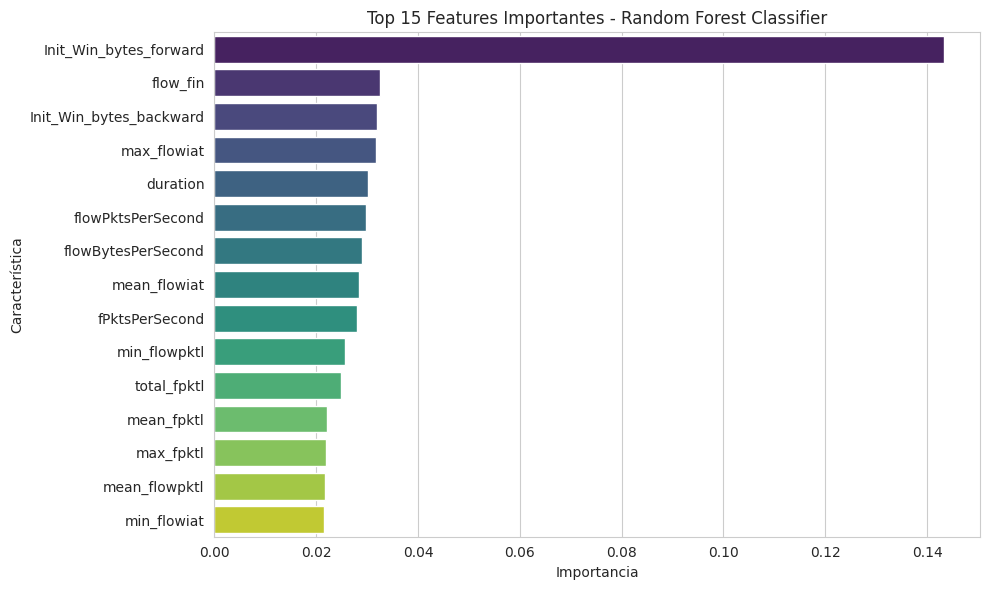

In [42]:
# Gráfica 1: Feature Importance (Random Forest Classifier)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': clf_rnd.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Features Importantes - Random Forest Classifier')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.savefig('django_server/results_app/static/images/feature_importance_classifier.png', dpi=150, bbox_inches='tight')
plt.show()

/tmp/ipykernel_13130/3983170854.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_reg, x='importance', y='feature', palette='plasma')


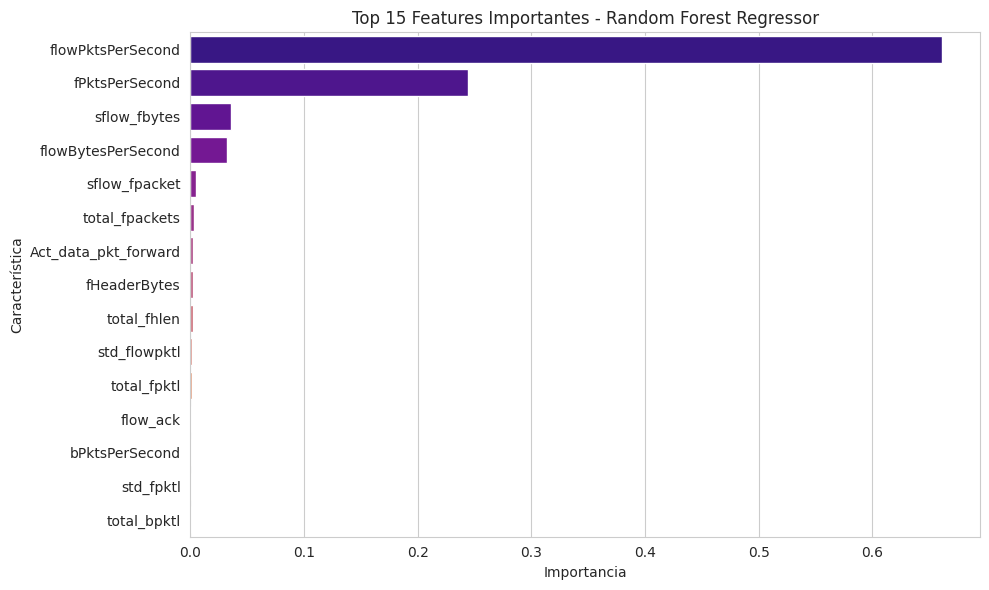

In [43]:
# Gráfica 2: Feature Importance (Random Forest Regressor)
feature_importance_reg = pd.DataFrame({
    'feature': X_train_reg.columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_reg, x='importance', y='feature', palette='plasma')
plt.title('Top 15 Features Importantes - Random Forest Regressor')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.savefig('django_server/results_app/static/images/feature_importance_regressor.png', dpi=150, bbox_inches='tight')
plt.show()

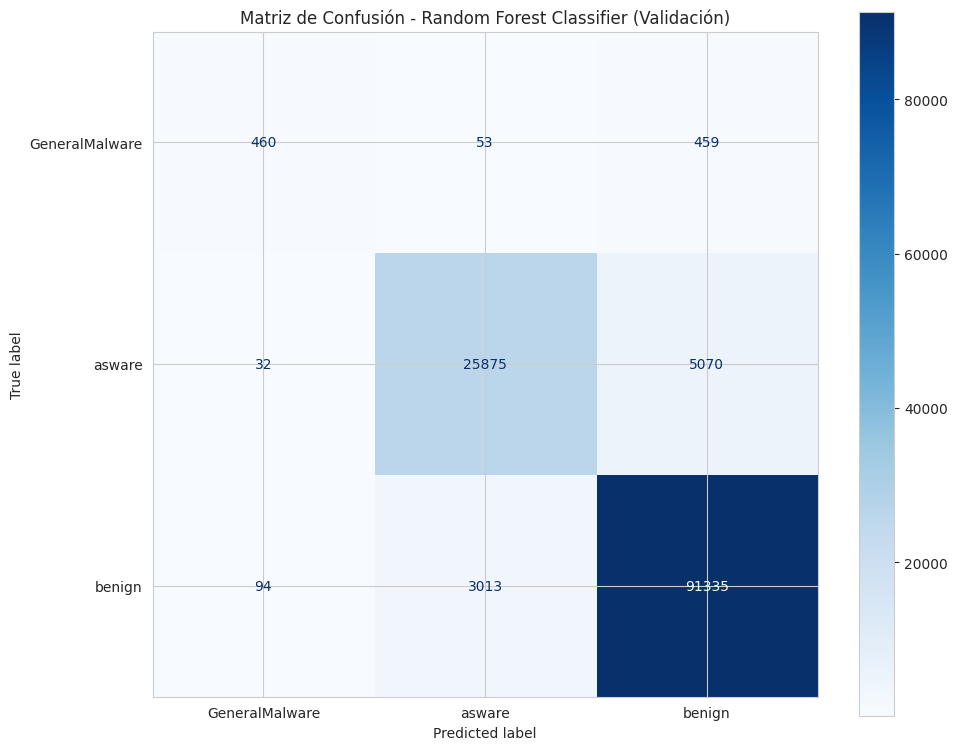

In [44]:
# Gráfica 3: Matriz de Confusión - Random Forest Classifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_rnd.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - Random Forest Classifier (Validación)')
plt.tight_layout()
plt.savefig('django_server/results_app/static/images/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

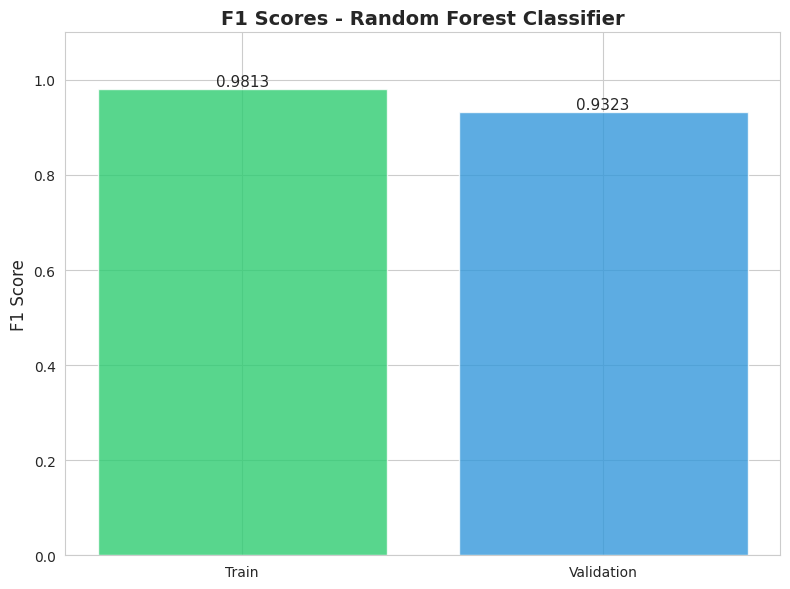

In [45]:
# Gráfica 4: Comparación de F1 Scores
f1_scores = {
    'Train': f1_score(y_train_pred, y_train, average='weighted'),
    'Validation': f1_score(y_pred, y_val, average='weighted')
}

plt.figure(figsize=(8, 6))
bars = plt.bar(f1_scores.keys(), f1_scores.values(), color=['#2ecc71', '#3498db'], alpha=0.8)
plt.title('F1 Scores - Random Forest Classifier', fontsize=14, fontweight='bold')
plt.ylabel('F1 Score', fontsize=12)
plt.ylim([0, 1.1])

# Añadir valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig('django_server/results_app/static/images/f1_scores_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

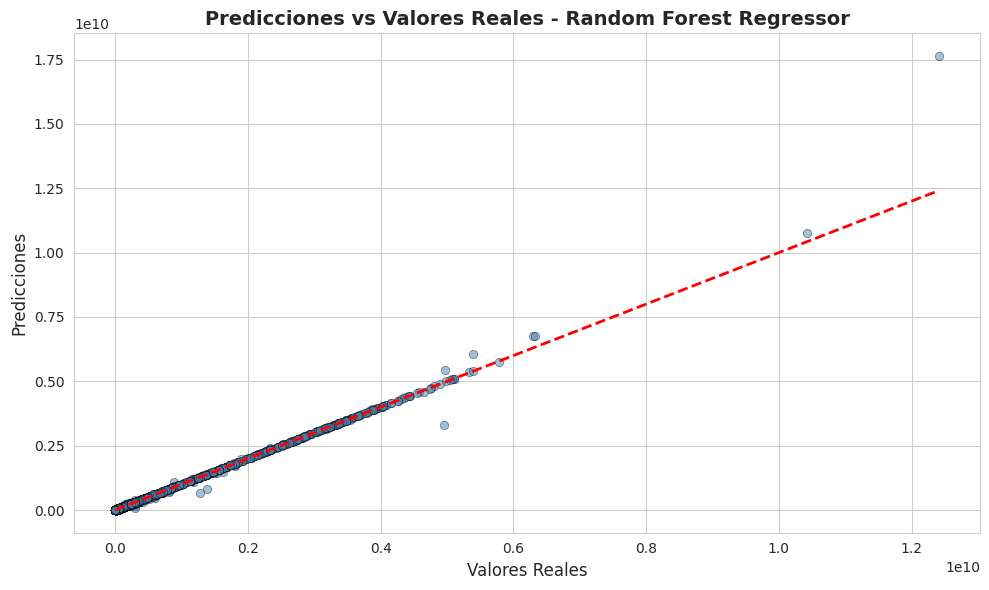

In [46]:
# Gráfica 5: Predicciones vs Valores Reales (Regressor)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_test_pred_reg, alpha=0.5, c='steelblue', edgecolors='k', linewidth=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Valores Reales', fontsize=12)
plt.ylabel('Predicciones', fontsize=12)
plt.title('Predicciones vs Valores Reales - Random Forest Regressor', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('django_server/results_app/static/images/predictions_vs_actual.png', dpi=150, bbox_inches='tight')
plt.show()

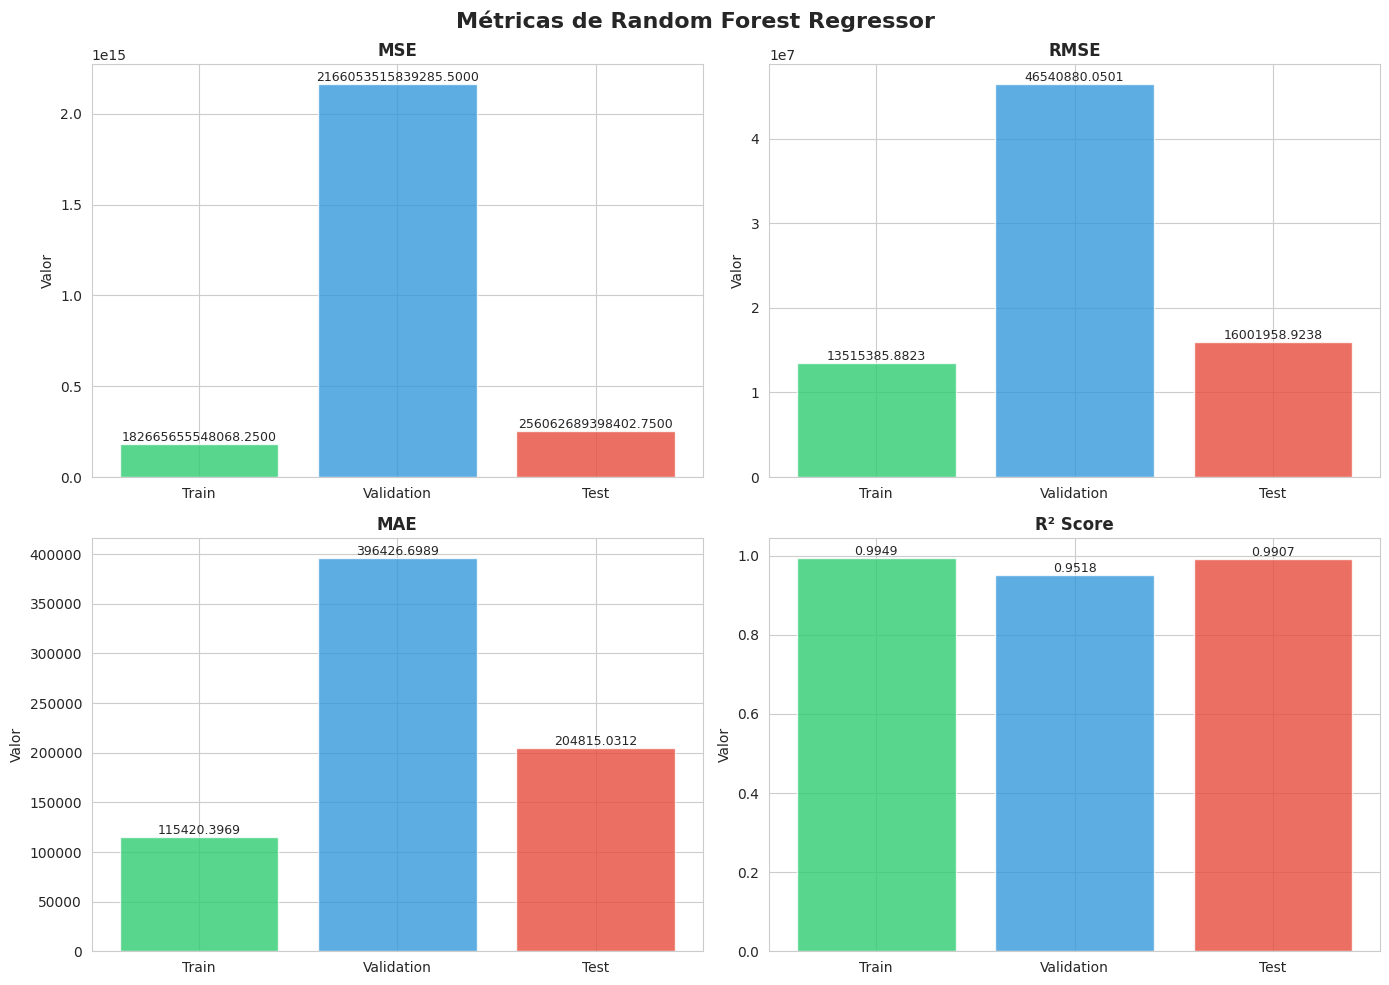

In [47]:
# Gráfica 6: Métricas del Regressor
metrics_data = {
    'Train': [mse_train, rmse_train, mae_train, r2_train],
    'Validation': [mse_val, rmse_val, mae_val, r2_val],
    'Test': [mse_test, rmse_test, mae_test, r2_test]
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_names = ['MSE', 'RMSE', 'MAE', 'R² Score']

for idx, (ax, metric_name) in enumerate(zip(axes.flat, metrics_names)):
    values = [metrics_data['Train'][idx], metrics_data['Validation'][idx], metrics_data['Test'][idx]]
    bars = ax.bar(['Train', 'Validation', 'Test'], values, color=['#2ecc71', '#3498db', '#e74c3c'], alpha=0.8)
    ax.set_title(metric_name, fontsize=12, fontweight='bold')
    ax.set_ylabel('Valor', fontsize=10)
    
    # Añadir valores en las barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.suptitle('Métricas de Random Forest Regressor', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('django_server/results_app/static/images/regression_metrics.png', dpi=150, bbox_inches='tight')
plt.show()